# Super Resolution and Fast Style Transfer

By https://arxiv.org/pdf/1603.08155.pdf and supplemential materials https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf

## Imports and data loading

In [19]:
import numpy as np
import bcolz
import importlib
import tensorflow as tf

import keras
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D
from keras.layers import AveragePooling2D, Input, BatchNormalization, Activation
from keras.layers import merge, Lambda
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras import backend as K
from keras.metrics import mse
from keras_tqdm import TQDMNotebookCallback

import vgg16_avg 
importlib.reload(vgg16_avg)
from vgg16_avg import VGG16_Avg

%matplotlib inline
import matplotlib.pyplot as plt
import utils2
importlib.reload(utils2)
from utils2 import save_array, load_array, plot, plot_multi, limit_mem

In [5]:
limit_mem()

Now load the data: small images (72x72) and their ground-truth(288x288)

In [6]:
small_imgs = load_array('../SuperResData/trn_resized_72.bc')
large_imgs = load_array('../SuperResData/trn_resized_288.bc')

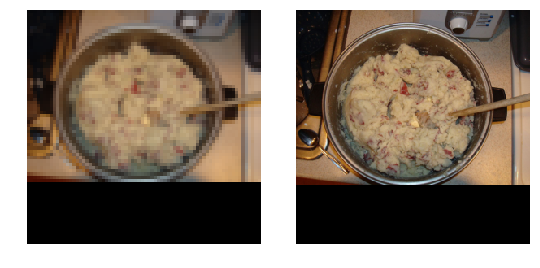

In [7]:
plot_multi([small_imgs[11].astype('uint8'), large_imgs[11].astype('uint8')],
           figsize=(15, 15))

## Upscale net

The Upscale network that will scale the small image into a big one.

In [8]:
def conv_block(inp, filters, size, stride=1, activation=True):
    ''' Define a convolutional block for the upscale network.
    '''
    x = Convolution2D(nb_filter=filters, nb_row=size[0], nb_col=size[1],
                      border_mode='same', name='')(inp)
    x = BatchNormalization()(x)
    if activation:
        return Activation(activation='relu')(x)
    else:
        return x

In [9]:
def res_block(inp, filters):
    x = conv_block(inp, filters=64, size=(3, 3))
    x = conv_block(x, filters=64, size=(3, 3), activation=False)
    x = merge([x, inp], mode='sum')
    return x

In [10]:
def deconv_block(inp, filters, size, output_shape, stride=2):
    x = Deconvolution2D(nb_filter=filters,
                        nb_row=size[0], nb_col=size[1],
                        output_shape=output_shape,
                        subsample=(stride, stride), border_mode='same')(inp)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [11]:
input_shape = small_imgs.shape[1:]
input_small = Input(shape=input_shape)
x = conv_block(input_small, filters=64, size=(9, 9))
x = res_block(x, 64)
x = res_block(x, 64)
x = res_block(x, 64)
x = res_block(x, 64)
x = deconv_block(x, 64, size=(3, 3), output_shape=(None, 144, 144, 64))
x = deconv_block(x, 64, size=(3, 3), output_shape=(None, 288, 288, 64))
x = Convolution2D(nb_filter=3, nb_row=9, nb_col=9,
                  activation='tanh', border_mode='same')(x)
enlarge_output = Lambda(lambda x: (x + 1) * 127.5)(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="", kernel_size=(9, 9), filters=64, padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="", kernel_size=(3, 3), filters=64, padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubu

In [12]:
enlarge_net = Model(input_small, enlarge_output)
enlarge_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
__________

## VGG for content features

In [13]:
channel_means = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess = Lambda(lambda x: (x - channel_means)[:, :, :, ::-1])

In [18]:
# vgg_input = Input(shape=large_imgs.shape[1:])
vgg = VGG16_Avg(include_top=False)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding=

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [20]:
vgg_content_features = Model(
    vgg.input, vgg.get_layer(name='block2_conv2').output)

In [26]:
# Test the VGG net
sample_image = K.constant(small_imgs[0][np.newaxis])
computed_features = K.get_value(vgg_content_features(sample_image))

In [28]:
computed_features.shape

(1, 36, 36, 128)

## Super Res net

Upscale the small image, and minimize the loss between the upscaled and the ground truth images.


In [29]:
truth_input = Input(shape=large_imgs.shape[1:])
truth_features = vgg_content_features(preprocess(truth_input))

In [30]:
upscaled_features = vgg_content_features(preprocess(enlarge_net.output))

In [31]:
truth_features, upscaled_features

(<tf.Tensor 'model_2_5/block2_conv2/Relu:0' shape=(?, 144, 144, 128) dtype=float32>,
 <tf.Tensor 'model_2_6/block2_conv2/Relu:0' shape=(?, ?, ?, 128) dtype=float32>)

In [32]:
def loss_func(x):
    rmse = K.sqrt(K.mean(K.square(x[0] - x[1]), axis=(1, 2)))
    return rmse


loss = Lambda(loss_func)([truth_features, upscaled_features])
loss

<tf.Tensor 'lambda_3/Sqrt:0' shape=(?, 128) dtype=float32>

In [33]:
super_res = Model((input_small, truth_input), loss)
lr = 1e-3
super_res.compile(optimizer=Adam(lr=lr), loss='mse')

In [ ]:
# params = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
fake_targets = np.zeros((large_imgs.shape[0],) + (128,))
super_res.fit([small_imgs, large_imgs], fake_targets,
              batch_size=16, nb_epoch=1, **params)

In [ ]:
K.set_value(super_res.optimizer.lr, 1e-4)
super_res.fit([small_imgs, large_imgs], fake_targets,
              batch_size=16, nb_epoch=2, **params)

In [ ]:
K.set_value(super_res.optimizer.lr, 1e-5)
super_res.fit([small_imgs, large_imgs], fake_targets,
              batch_size=16, nb_epoch=2, **params)

In [47]:
final_model = Model(input_small, enlarge_output)
final_model.save('enlarge_model.hdf5')

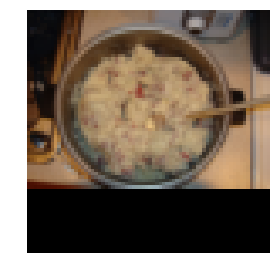

In [48]:
img_index = 11
test_img = small_imgs[img_index:img_index + 1]
target_img = large_imgs[img_index].astype('uint8')
plot_multi(test_img.astype('uint8'), figsize=(15, 15))

In [49]:
enlarged_img = final_model.predict(test_img)
enlarged_img = np.squeeze(enlarged_img.astype('uint8'))
enlarged_img.shape

(288, 288, 3)

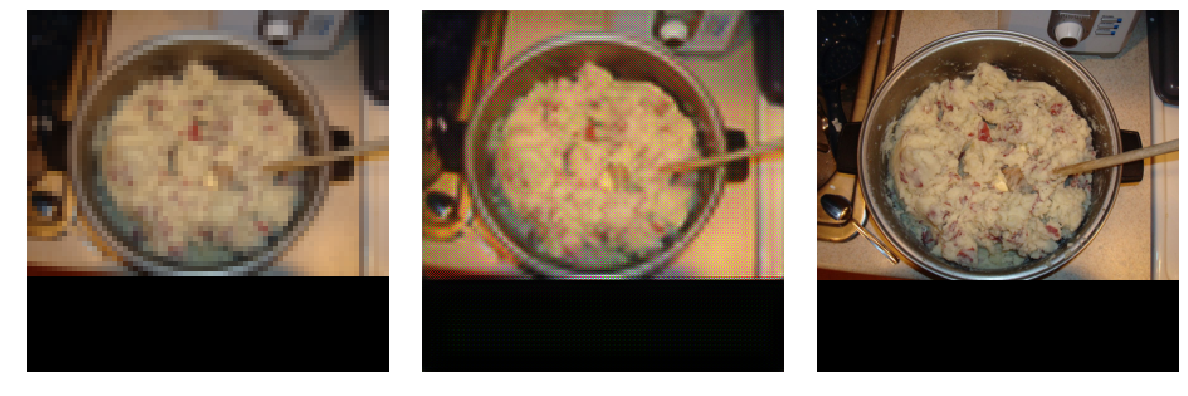

In [50]:
small_img = np.squeeze(test_img.astype('uint8'))
plot_multi([small_img, enlarged_img, target_img], figsize=(22, 22))